In [1]:
# Connect to google drive
import os
from google.colab import drive
drive.mount('/content/drive')

# content in your drive is now available via "/content/drive/My Drive"

Mounted at /content/drive


In [2]:
# Import data and unzip files to folder
!unzip /content/drive/MyDrive/covid_radiography_data/COVID-19_Radiography_Dataset.zip

流式输出内容被截断，只能显示最后 5000 行内容。
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7924.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7925.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7926.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7927.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7928.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7929.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-793.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7930.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7931.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7932.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7933.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7934.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7935.png  
  inflating: COVID-19_Rad

In [3]:
# Load libraries and then download data

import sys
import time
import cv2
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import os
import zipfile

from sklearn.model_selection import train_test_split

from tensorflow.python.keras.utils import np_utils
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization
from tensorflow.python.keras.layers.convolutional import Conv2D, MaxPooling2D 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from tensorflow.keras.applications import VGG19, ResNet50, InceptionV3

In [4]:
# Extracting all filenames iteratively
base_path = 'COVID-19_Radiography_Dataset'
categories = ['COVID/images', 'Normal/images', 'Viral Pneumonia/images']

# load file names to fnames list object
fnames = []
for category in categories:
    image_folder = os.path.join(base_path, category)
    file_names = os.listdir(image_folder)
    full_path = [os.path.join(image_folder, file_name) for file_name in file_names]
    fnames.append(full_path)

print('number of images for each category:', [len(f) for f in fnames])
print(fnames[0:2]) #examples of file names

number of images for each category: [3616, 10192, 1345]
[['COVID-19_Radiography_Dataset/COVID/images/COVID-1960.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-904.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-2435.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-787.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-2157.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-1257.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-3379.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-819.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-1690.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-1338.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-3508.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-1990.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-617.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-3309.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-2410.png', 'COVID-19_Radiography_Dataset/COVID/images/COV

In [5]:
#Reduce number of images to first 1345 for each category
fnames[0]=fnames[0][0:1344]
fnames[1]=fnames[1][0:1344]
fnames[2]=fnames[2][0:1344]

In [7]:
# Import image, load to array of shape height, width, channels, then min/max transform.
# Write preprocessor that will match up with model's expected input shape.
from keras.preprocessing import image
import numpy as np
from PIL import Image

def preprocessor(img_path):
        img = Image.open(img_path).convert("RGB").resize((192,192)) # import image, make sure it's RGB and resize to height and width you want.
        img = (np.float32(img)-1.)/(255-1.) # min max transformation
        img=img.reshape((192,192,3)) # Create final shape as array with correct dimensions for Keras
        return img



#Try on single flower file (imports file and preprocesses it to data with following shape)
preprocessor('COVID-19_Radiography_Dataset/COVID/images/COVID-2273.png').shape

(192, 192, 3)

In [7]:
#Import image files iteratively and preprocess them into array of correctly structured data

# Create list of file paths
image_filepaths=fnames[0]+fnames[1]+fnames[2]

# Iteratively import and preprocess data using map function

# map functions apply your preprocessor function one step at a time to each filepath
preprocessed_image_data=list(map(preprocessor,image_filepaths ))

# Object needs to be an array rather than a list for Keras (map returns to list object)
X= np.array(preprocessed_image_data) # Assigning to X to highlight that this represents feature input data for our model

In [8]:
print(len(X) ) #same number of elements as filenames
print(X.shape ) #dimensions now 192,192,3 for all images
print(X.min().round() ) #min value of every image is zero
print(X.max() ) #max value of every image is one


4032
(4032, 192, 192, 3)
-0.0
1.0


In [9]:
# Create y data made up of correctly ordered labels from file folders
from itertools import repeat

# Recall that we have five folders with the following number of images in each folder 
#...corresponding to each flower type

print('number of images for each category:', [len(f) for f in fnames])
covid=list(repeat("COVID", 1344))
normal=list(repeat("NORMAL", 1344))
pneumonia=list(repeat("PNEUMONIA", 1344))

#combine into single list of y labels
y_labels = covid+normal+pneumonia

#check length, same as X above
print(len(y_labels) )

# Need to one hot encode for Keras.  Let's use Pandas

import pandas as pd
y=pd.get_dummies(y_labels)

display(y)

number of images for each category: [1344, 1344, 1344]
4032


COVID  NORMAL  PNEUMONIA
0         1       0          0
1         1       0          0
2         1       0          0
3         1       0          0
4         1       0          0
...     ...     ...        ...
4027      0       0          1
4028      0       0          1
4029      0       0          1
4030      0       0          1
4031      0       0          1

[4032 rows x 3 columns]

## Visualize images that demonstrate when x-rays demonstrate Covid Positivity and when they do not (You can present visuals of each category in the data if you would like to.).

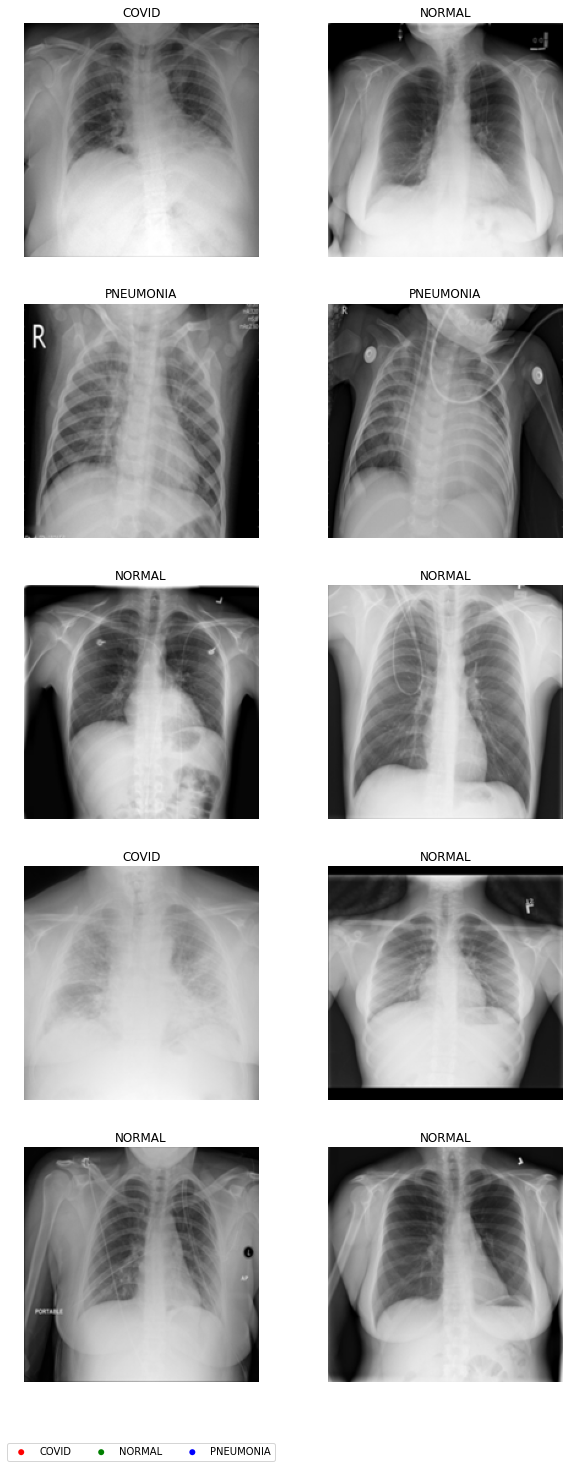

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Define figure and axes objects
fig, axs = plt.subplots(5, 2, figsize=(10, 25))

# Define categories and their corresponding colors
categories = ['COVID', 'NORMAL', 'PNEUMONIA']
colors = ['red', 'green', 'blue']

# Plot images and corresponding labels
for i in range(5):
    for j in range(2):
        index = np.random.randint(0, len(X))
        axs[i, j].imshow(X[index])
        axs[i, j].set_title(y_labels[index])
        axs[i, j].axis('off')
        
# Add category labels
for i, category in enumerate(categories):
    axs[4, 0].scatter([], [], c=colors[i], label=category, edgecolors='none')
    
# Add legend
axs[4, 0].legend(loc='center', bbox_to_anchor=(0.5, -0.3), ncol=3)

plt.show()

## Discuss the dataset in general terms and describe why building a predictive model using this data might be practically useful.  Who could benefit from a model like this? Explain.

This dataset stores a large amount of image data labeled COVID-19, pneumonia or normal chest X-ray images, and we can use this data to build a predictive model that can help healthcare professionals accurately diagnose COVID-19 and pneumonia, thereby reducing the burden on healthcare professionals and allowing for better diagnosis, and can be combined with more sophisticated models to do so. healthcare automation, thus making this model beneficial to healthcare practitioners and public health officials worldwide.

## Run at least three prediction models to try to predict x-ray images well.
  - Use transfer learning for at least one of these models
  - Discuss which models performed better and point out relevant hyper-parameter values for successful models.
  - Submit your best three models to the leader board for the Covid X-ray Diagnostic AI Model Share competition.

In [11]:
# ======Train test split resized images (Hackathon Note!! Use same train test split to be able to submit predictions to leaderboard!)=======================================
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.32, random_state = 1987)


X_test.shape, y_test.shape

((1291, 192, 192, 3), (1291, 3))

In [12]:
#Clear objects from memory
del(X)
del(y)
del(preprocessed_image_data)

In [13]:
#Save data to be able to reload quickly if memory crashes or if you run Runtime>Restart Runtime
import pickle

# Open a file and use dump()
with open('X_train.pkl', 'wb') as file:
    # A new file will be created
    pickle.dump(X_train, file)

#Save data
import pickle

# Open a file and use dump()
with open('X_test.pkl', 'wb') as file:
    # A new file will be created
    pickle.dump(X_test, file)

#Save data
import pickle

# Open a file and use dump()
with open('y_train.pkl', 'wb') as file:
    # A new file will be created
    pickle.dump(y_train, file)


# Open a file and use dump()
with open('y_test.pkl', 'wb') as file:
    # A new file will be created
    pickle.dump(y_test, file)

In [6]:
#If you run out of Colab memory restart runtime, reload data and try again
import pickle
  
# Open the file in binary mode
with open('X_train.pkl', 'rb') as file:
    # Call load method to deserialze
    X_train = pickle.load(file)

# Open the file in binary mode
with open('y_train.pkl', 'rb') as file:
    # Call load method to deserialze
    y_train = pickle.load(file)

### Model1: In the first model, I increased the number of epochs to 10. As well as using tf.keras.layer.Dropout to add a dropout layer with a rate of 0.25 after each max pool layer. Also, a learning rate scheduler is defined with an initial learning rate of 0.001, which decreases by a factor of 10 after 10 epochs. callback parameters in model.fit are used to add the learning rate scheduler, early stop and model checkpoint callbacks.

In [15]:
import tensorflow as tf

with tf.device('/device:GPU:0'):
    model = tf.keras.Sequential([
        # input: images of size Sample size, height, width, channels 1x192x192x3 pixels (the three stands for RGB channels)
        tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu', input_shape=(192, 192, 3)),
        tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=2),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Conv2D(kernel_size=3, filters=64, padding='same', activation='relu'),
        tf.keras.layers.Conv2D(kernel_size=1, filters=64, padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=2),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Conv2D(kernel_size=3, filters=128, padding='same', activation='relu'),
        tf.keras.layers.Conv2D(kernel_size=1, filters=128, padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=2),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Conv2D(kernel_size=3, filters=512, padding='same', activation='relu'),
        tf.keras.layers.Conv2D(kernel_size=1, filters=512, padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=2),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Conv2D(kernel_size=3, filters=512, padding='same', activation='relu'),
        tf.keras.layers.Conv2D(kernel_size=1, filters=512, padding='same', activation='relu'),
        tf.keras.layers.Flatten(),
        # classifying into 5 categories
        tf.keras.layers.Dense(3, activation='softmax')
    ])
    
    # define learning rate scheduler
    def lr_schedule(epoch):
        lr = 0.001
        if epoch > 10:
            lr *= 0.1
        return lr
    
    # compile the model with learning rate scheduler and dropout layers
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001), 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    # fit the model with learning rate scheduler and dropout layers
    model.fit(X_train, y_train, 
              epochs=20, 
              verbose=1,
              validation_split=0.2,
              callbacks=[tf.keras.callbacks.LearningRateScheduler(lr_schedule),
                         tf.keras.callbacks.EarlyStopping(patience=3),
                         tf.keras.callbacks.ModelCheckpoint('model.h5', save_best_only=True)]
             )

Epoch 1/20
69/69 [==============================] - 25s 151ms/step - loss: 0.8294 - accuracy: 0.6150 - val_loss: 0.6732 - val_accuracy: 0.7268 - lr: 0.0010
Epoch 2/20
69/69 [==============================] - 9s 125ms/step - loss: 0.6033 - accuracy: 0.7313 - val_loss: 0.6189 - val_accuracy: 0.7687 - lr: 0.0010
Epoch 3/20
69/69 [==============================] - 8s 120ms/step - loss: 0.5522 - accuracy: 0.7646 - val_loss: 0.6044 - val_accuracy: 0.7031 - lr: 0.0010
Epoch 4/20
69/69 [==============================] - 8s 119ms/step - loss: 0.4964 - accuracy: 0.7783 - val_loss: 0.7586 - val_accuracy: 0.6321 - lr: 0.0010
Epoch 5/20
69/69 [==============================] - 8s 120ms/step - loss: 0.4480 - accuracy: 0.8066 - val_loss: 0.4846 - val_accuracy: 0.7869 - lr: 0.0010
Epoch 6/20
69/69 [==============================] - 8s 122ms/step - loss: 0.4135 - accuracy: 0.8148 - val_loss: 0.3728 - val_accuracy: 0.8361 - lr: 0.0010
Epoch 7/20
69/69 [==============================] - 8s 117ms/step - l

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 192, 192, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 192, 192, 32)      1056      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 96, 96, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 96, 96, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 96, 96, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 96, 96, 64)        4160      
                                                        

In [17]:
model.save("model1.h5", save_format="h5")

In [18]:
# Reload model and data
import tensorflow as tf
model = tf.keras.models.load_model('model1.h5',compile=False)
model.compile(
    optimizer="adam", # to use callback set lr arg such as Adam(lr=0.001) instead
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 192, 192, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 192, 192, 32)      1056      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 96, 96, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 96, 96, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 96, 96, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 96, 96, 64)        4160      
                                                        

In [20]:
! pip install aimodelshare --upgrade


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 967.8/967.8 KB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 74.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 74.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.4/178.4 KB 13.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.8/511.8 MB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.3/442.3 KB 42.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.0/147.0 KB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.7/132.7 KB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.0/294.0 KB 27.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 69.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.3/9

In [24]:
# Save tf.keras model (or any tensorflow model) to local ONNX file
from aimodelshare.aimsonnx import model_to_onnx

onnx_model = model_to_onnx(model, framework='keras',
                          transfer_learning=False,
                          deep_learning=True)

with open("model1.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

Cause: Unable to locate the source code of <function trace_model_call.<locals>._wrapped_model at 0x7fba87de3820>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [4]:
#Use X_test data to generate model predictions and make leaderboard submission

#Generate and save predictions

#Load preprocessed data
#If you run out of Colab memory restart runtime, reload data and try again
import pickle
  
# Open the file in binary mode
with open('X_test.pkl', 'rb') as file:
    # Call load method to deserialze
    X_test = pickle.load(file)

# Open the file in binary mode
with open('y_train.pkl', 'rb') as file:
    # Call load method to deserialze
    y_train = pickle.load(file)
    
prediction_column_index=model.predict(X_test).argmax(axis=1)

# extract correct prediction labels 
prediction_labels = [y_train.columns[i] for i in prediction_column_index]

41/41 [==============================] - 8s 81ms/step


In [27]:
apiurl='https://bb4mkgq8sb.execute-api.us-east-2.amazonaws.com/prod/m'

import aimodelshare as ai
experiment= ai.Experiment(apiurl)

from aimodelshare.aws import set_credentials
set_credentials(apiurl=apiurl)

AI Modelshare Username:··········
AI Modelshare Password:··········
AI Model Share login credentials set successfully.


In [28]:
#Submit Model with predictions only (if you cannot save an onnx file): 

#-- Generate predicted y values (Model 1)
#Note: Keras predict returns the predicted column index location for classification models
prediction_column_index=model.predict(X_test).argmax(axis=1)

# extract correct prediction labels 
prediction_labels = [y_train.columns[i] for i in prediction_column_index]

# Submit Model 1 to Competition Leaderboard
experiment.submit_model(model_filepath = None,
                                 preprocessor_filepath=None,
                                 prediction_submission=prediction_labels)

41/41 [==============================] - 1s 33ms/step
Insert search tags to help users find your model (optional): Model1
Provide any useful notes about your model (optional): Group Rice cooker

Your model has been submitted as model version 251

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.org/detail/model:3340


In [29]:
data = experiment.get_leaderboard()
experiment.stylize_leaderboard(data)

### Model 2:  VGG16

In [30]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten

In [31]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(192, 192, 3))
base_model.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 192, 192, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 192, 192, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 192, 192, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 96, 96, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 96, 96, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 96, 96, 128)       147584    
                                                              

In [32]:
base_model.trainable = False
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 192, 192, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 192, 192, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 192, 192, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 96, 96, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 96, 96, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 96, 96, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 48, 48, 128)       0     

In [33]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model

# load VGG16 model without top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(192, 192, 3))

# add custom classifier layers
x = base_model.output
x = Flatten()(x)
x = Dense(112, activation='relu')(x)
predictions = Dense(3, activation='softmax')(x)

# create the new model
model = Model(inputs=base_model.input, outputs=predictions)

# print the model summary
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 192, 192, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 192, 192, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 192, 192, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 96, 96, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 96, 96, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 96, 96, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 48, 48, 128)       0     

In [34]:
# Fit VGG16 model with frozen imagent weights and new input/output layer shapes (outputs have trainable parameters)
import tensorflow as tf
with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.
  from tensorflow.python.keras.callbacks import ReduceLROnPlateau
  from tensorflow.python.keras.callbacks import ModelCheckpoint
  
  mc = ModelCheckpoint('best_model.h5', monitor='val_acc',mode='max', verbose=1, save_best_only=True) # evaluating val_acc maximization
  red_lr= ReduceLROnPlateau(monitor='val_acc',patience=2,verbose=1,factor=0.5, min_lr=0.001) # dividing lr by 2 when val_accuracy fails to improve after 2 epochs

  model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['acc']) 

  model.fit(X_train, y_train,batch_size=1,
          epochs = 10, verbose=1,validation_split=.2,callbacks=[mc,red_lr])

Epoch 1/10
2191/2192 [============================>.] - ETA: 0s - loss: nan - acc: 0.3364
Epoch 00001: val_acc improved from -inf to 0.32058, saving model to best_model.h5
2192/2192 [==============================] - 71s 30ms/step - loss: nan - acc: 0.3367 - val_loss: nan - val_acc: 0.3206 - lr: 0.0100
Epoch 2/10
2192/2192 [==============================] - ETA: 0s - loss: nan - acc: 0.3367
Epoch 00002: val_acc did not improve from 0.32058
2192/2192 [==============================] - 66s 30ms/step - loss: nan - acc: 0.3367 - val_loss: nan - val_acc: 0.3206 - lr: 0.0100
Epoch 3/10
2192/2192 [==============================] - ETA: 0s - loss: nan - acc: 0.3367
Epoch 00003: val_acc did not improve from 0.32058

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.
2192/2192 [==============================] - 65s 30ms/step - loss: nan - acc: 0.3367 - val_loss: nan - val_acc: 0.3206 - lr: 0.0100
Epoch 4/10
2192/2192 [==============================] - ETA: 0s - loss: 

In [35]:
model.save("model2.h5", save_format="h5")

In [1]:
# Reload model and data
import tensorflow as tf
model = tf.keras.models.load_model('model2.h5',compile=False)
model.compile(
    optimizer="adam", # to use callback set lr arg such as Adam(lr=0.001) instead
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 192, 192, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 192, 192, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 192, 192, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 96, 96, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 96, 96, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 96, 96, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 48, 48, 128)       0     

In [2]:
# Save tf.keras model (or any tensorflow model) to local ONNX file
from aimodelshare.aimsonnx import model_to_onnx

onnx_model = model_to_onnx(model, framework='keras',
                          transfer_learning=False,
                          deep_learning=True)

with open("model.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

In [9]:
# Save preprocessor function (may need to reload function in cell above)
import aimodelshare as ai
ai.export_preprocessor(preprocessor,"")

Your preprocessor is now saved to 'preprocessor.zip'


In [3]:
#Use X_test data to generate model predictions and make leaderboard submission

#Generate and save predictions

#Load preprocessed data
#If you run out of Colab memory restart runtime, reload data and try again
import pickle
  
# Open the file in binary mode
with open('X_test.pkl', 'rb') as file:
    # Call load method to deserialze
    X_test = pickle.load(file)

# Open the file in binary mode
with open('y_train.pkl', 'rb') as file:
    # Call load method to deserialze
    y_train = pickle.load(file)
    
prediction_column_index=model.predict(X_test).argmax(axis=1)

# extract correct prediction labels 
prediction_labels = [y_train.columns[i] for i in prediction_column_index]

41/41 [==============================] - 13s 124ms/step


In [5]:
apiurl='https://bb4mkgq8sb.execute-api.us-east-2.amazonaws.com/prod/m'

import aimodelshare as ai
experiment= ai.Experiment(apiurl)

from aimodelshare.aws import set_credentials
set_credentials(apiurl=apiurl)

AI Modelshare Username:··········
AI Modelshare Password:··········
AI Model Share login credentials set successfully.


In [10]:
# Submit Model 2 to Competition Leaderboard
experiment.submit_model(model_filepath = "model.onnx",
                                 preprocessor_filepath="preprocessor.zip",
                                 prediction_submission=prediction_labels)

Insert search tags to help users find your model (optional): model2
Provide any useful notes about your model (optional): group rice cooker

Your model has been submitted as model version 252

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.org/detail/model:3340


In [11]:
data = experiment.get_leaderboard()
experiment.stylize_leaderboard(data)

###Model3: 

In [2]:
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50

# Define the input shape
input_shape=(192, 192, 3)

# Load the ResNet50 model pretrained on ImageNet
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze the layers in the base model
base_model.trainable = False

# Add a new classifier on top of the base model
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(3, activation='softmax')(x)

# Define the new model
model = Model(inputs=base_model.input, outputs=predictions)

# Print the model summary
model.summary()


94765736/94765736 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 192, 192, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 198, 198, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 96, 96, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization

In [7]:
model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['acc']) 

model.fit(X_train, y_train,epochs = 1, verbose=1,validation_split=.2)

69/69 [==============================] - 13s 146ms/step - loss: 2.0114 - acc: 0.3358 - val_loss: 1.0985 - val_acc: 0.3370


In [8]:
model.save("model3.h5", save_format="h5")

In [1]:
# Reload model and data
import tensorflow as tf
model = tf.keras.models.load_model('model3.h5',compile=False)
model.compile(
    optimizer="adam", # to use callback set lr arg such as Adam(lr=0.001) instead
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 192, 192, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 198, 198, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 96, 96, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 96, 96, 64)   256         ['conv1_conv[0][0]']         

In [2]:
# Save tf.keras model (or any tensorflow model) to local ONNX file
from aimodelshare.aimsonnx import model_to_onnx

onnx_model = model_to_onnx(model, framework='keras',
                          transfer_learning=False,
                          deep_learning=True)

with open("model.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

In [3]:
#Use X_test data to generate model predictions and make leaderboard submission

#Generate and save predictions

#Load preprocessed data
#If you run out of Colab memory restart runtime, reload data and try again
import pickle
  
# Open the file in binary mode
with open('X_test.pkl', 'rb') as file:
    # Call load method to deserialze
    X_test = pickle.load(file)

# Open the file in binary mode
with open('y_train.pkl', 'rb') as file:
    # Call load method to deserialze
    y_train = pickle.load(file)
    
prediction_column_index=model.predict(X_test).argmax(axis=1)

# extract correct prediction labels 
prediction_labels = [y_train.columns[i] for i in prediction_column_index]

41/41 [==============================] - 14s 78ms/step


In [4]:
apiurl='https://bb4mkgq8sb.execute-api.us-east-2.amazonaws.com/prod/m'

import aimodelshare as ai
experiment= ai.Experiment(apiurl)

from aimodelshare.aws import set_credentials
set_credentials(apiurl=apiurl)

AI Modelshare Username:··········
AI Modelshare Password:··········
AI Model Share login credentials set successfully.


In [5]:
# Submit Model 3 to Competition Leaderboard
experiment.submit_model(model_filepath = "model.onnx",
                                 preprocessor_filepath="preprocessor.zip",
                                 prediction_submission=prediction_labels)

Insert search tags to help users find your model (optional): model3
Provide any useful notes about your model (optional): Group rice cooker

Your model has been submitted as model version 253

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.org/detail/model:3340


In [6]:
data = experiment.get_leaderboard()
experiment.stylize_leaderboard(data)

In our group's attempts, model1 achieved the best results. However, model2 and model3b, which were used as transfer learning, did not perform well. Through these two weeks, we learned that transfer learning is a powerful technique to improve the performance of deep learning models. It involves taking pre-trained models that have been trained on large datasets and reusing their learned representations to solve similar tasks. However, transfer learning requires careful attention to training parameters and dataset features to avoid overfitting, incompatible data, or incorrect architectures. It is important to fine-tune the pre-trained models, select the appropriate architecture, and carefully tune the hyperparameters to achieve optimal performance. This may be the reason why transfer learning is not ideal, we have limited knowledge about transfer learning for now and hope to use it better after learning more。

z